# Dirichlet mixture of multinomial distributions for HTTP Error Codes

## Detecting microservice failures post deployment
Deploying a new version of a microservice should be safe, but sometimes it isn't. Deployments of new versions typically follow a slow, incremental release and most new code should be behind feature flags/toggles. In the rare case that your service is not working as expected post deployment, we want to detect that as early as possible.

## How do we detect failures?
Assuming your microservice is hidden behind an API, we can compare the distribution of HTTP status codes between the two versions to tell us if we have a problem. The benefit to looking at the full distribution is that just a change in error rates can miss small but impactful errors. For example, in deploying a new routing solution our error rate monitoring did not alert post deployment even though the regression environments were inoperable. The issue turned out to be 411 errors returned when HAProxy did not properly handle requests with Content-Length = 0. Our alert didn't fire because the 411 errors happened at a very low rate compared to the volume of 404 status codes. 

## Describing the distribution of HTTP Status Codes



Links that helped me build this:
1. https://www.pymc.io/projects/docs/en/v3.11.4/pymc-examples/examples/mixture_models/dirichlet_mixture_of_multinomials.html


## Before we get to that - some python imports

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy as sp
import scipy.stats
import seaborn as sns

In [2]:
true_conc = 6.0
true_frac = np.array([0.45, 0.30, 0.15, 0.09, 0.01])
k = len(true_frac)  # Number of different tree species observed
n = 10  # Number of forests observed
total_count = 50

true_p = sp.stats.dirichlet(true_conc * true_frac).rvs(size=n)
observed_counts = np.vstack([sp.stats.multinomial(n=total_count, p=p_i).rvs() for p_i in true_p])

observed_counts

array([[20, 28,  1,  1,  0],
       [32, 12,  5,  1,  0],
       [21, 10, 16,  3,  0],
       [34, 12,  2,  2,  0],
       [17, 33,  0,  0,  0],
       [18, 22,  0, 10,  0],
       [18, 27,  5,  0,  0],
       [11, 18, 17,  4,  0],
       [28,  3, 12,  7,  0],
       [ 9, 13, 26,  2,  0]])

In [5]:
with pm.Model() as model_dm_marginalized:
    frac = pm.Dirichlet("frac", a=np.ones(k))
    conc = pm.Lognormal("conc", mu=1, sigma=1)
    counts = pm.DirichletMultinomial(
        "counts", n=total_count, a=frac * conc, shape=(n, k), observed=observed_counts
    )

pm.model_to_graphviz(model_dm_marginalized)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [6]:
with model_dm_marginalized:
    trace_dm_marginalized = pm.sample(chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


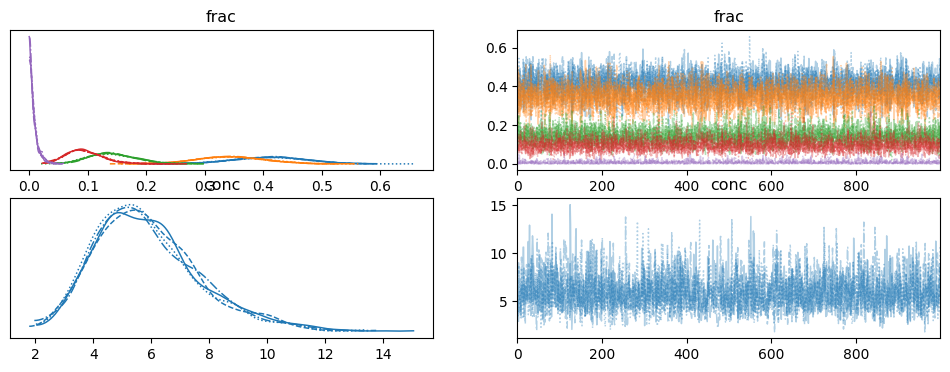

In [7]:
az.plot_trace(data=trace_dm_marginalized, var_names=["frac", "conc"]);

In [8]:
summary_multinomial = az.summary(trace_dm_marginalized, var_names=["frac", "conc"])
#summary_multinomial = summary_multinomial.assign(
#    ess_mean_per_sec=lambda x: x.ess_mean / trace_multinomial.posterior.sampling_time,
#)

summary_multinomial


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
frac[0],0.410,0.062,0.292,0.522,0.001,0.001,5762.0,3360.0,1.0
frac[1],0.344,0.058,0.240,0.458,0.001,0.000,6891.0,3166.0,1.0
frac[2],0.143,0.041,0.070,0.220,0.001,0.000,4629.0,2700.0,1.0
frac[3],0.095,0.032,0.038,0.154,0.001,0.000,3568.0,2814.0,1.0
frac[4],0.008,0.008,0.000,0.022,0.000,0.000,1789.0,1357.0,1.0
conc,5.881,1.853,2.507,9.268,0.036,0.026,2623.0,2339.0,1.0


/home/patrick/.local/share/virtualenvs/pymcsreexamples-LeBqr9Uq/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/home/patrick/.local/share/virtualenvs/pymcsreexamples-LeBqr9Uq/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


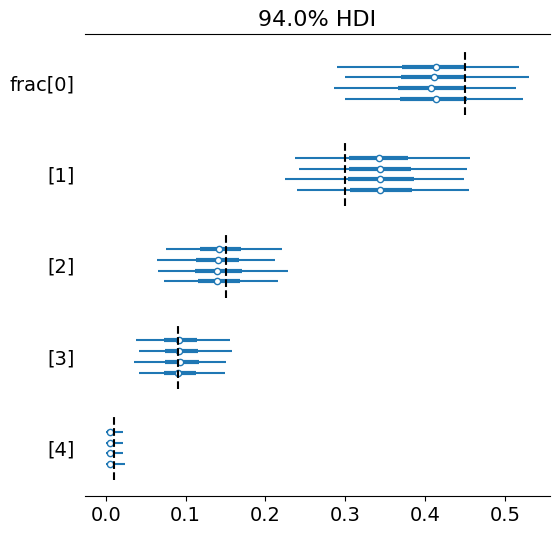

In [9]:
az.plot_forest(trace_dm_marginalized, var_names=["frac"])
for j, (y_tick, frac_j) in enumerate(zip(plt.gca().get_yticks(), reversed(true_frac))):
    plt.vlines(frac_j, ymin=y_tick - 0.45, ymax=y_tick + 0.45, color="black", linestyle="--")

In [10]:
with pm.Model() as model_multinomial:
    frac = pm.Dirichlet("frac", a=np.ones(k))
    counts = pm.Multinomial("counts", n=total_count, p=frac, shape=(n, k), observed=observed_counts)

pm.model_to_graphviz(model_multinomial)

with model_multinomial:
    trace_multinomial = pm.sample(
        draws=int(5e3), chains=4, step=pm.Metropolis(), return_inferencedata=True
    )



Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [frac]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [11]:
az.compare(
    {"multinomial": trace_multinomial, "dirichlet_multinomial": trace_dm_marginalized}, ic="loo"
)

TypeError: Encountered error in ELPD computation of compare.